In [16]:
import spaudiopy as spa
import pyfar as pf
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import soundfile as sf
import glob
# import spharpy

Generelle Idee meines Ansatzes:
- Ausgangspunkt: Spherical Harmonics
    - SH mit virtuellen LS decodieren oder
    - SH per Beamforming extrahieren
- Berechnung der Parameter
- Plot
- Profit

In [17]:
# Definition von Variablen 
fs = 44100
# audio,fs = sf.read("HOA\HOA_A10p_S00_R00_CH01.wav")

# Definition der Evaluationszeiträume
tl = 15
tu = 100

tl = round((tl*(10**(-3)))*fs)
tu = round((tu*(10**(-3)))*fs)


# Erstellung der Multifile-IR
# RIR_Mf = np.zeros((16,224910))
# RIR_HOA = np.zeros((16,224910))
# n = 0
# HOA_files = np.zeros(16)

# for i in [f'{i:>02}' for i in range(1, 16)]:
#     HOA_files[n] = str("HOA\HOA_A10p_S00_R00_CH" + i + ".wav")
#     # RIR_Mf[n] = spa.sig.MonoSignal.from_file("HOA\HOA_A10p_S00_R00_CH" + i + ".wav", fs)       # RIR, fs = 48000)
#     n = n+1

# RIR_HOA = spa.io.load_audio(HOA_files)

# for i in [f'{i:>02}' for i in range(1, 16)]:
#     RIR[n] = spa.sig.MonoSignal.from_file("HOA\HOA_A10p_S00_R00_CH" + i + ".wav")
#     n = n+1

# sp.io.wavfile.write('RIR_MultiSignal.wav', 44100, RIR)
# RIR_Mf = spa.sig.MultiSignal.from_file('RIR_MultiSignal.wav')       # RIR, fs = 48000)

# load all Files
HOA_paths = glob.glob("HOA\*.wav")
print(len(HOA_paths), "HOA files found. = 3rd order ambisonics")
HOAS = spa.io.load_audio(HOA_paths)


# load only Ambisonics B-Format components
n = 0
# HOA_files_b = str(np.zeros(4))
HOA_files_b = ["" for x in range(4)]

for i in [f'{i:>02}' for i in range(1, 5)]:
    HOA_files_b[n] = "HOA\HOA_A10p_S00_R00_CH" + i + ".wav"
    n = n+1

ambi_b = spa.io.load_audio(HOA_files_b)
ambi_b = spa.sig.AmbiBSignal.sh_to_b(ambi_b)

16 HOA files found. = 3rd order ambisonics


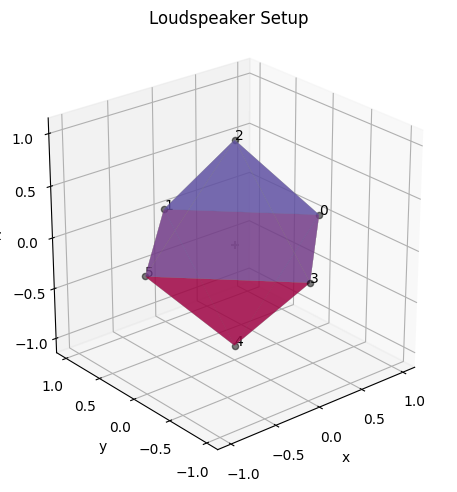

In [18]:
# Berechnung der Schalleinfallsrichtungen + Energien über LS:

# Definition des Lautsprechersetups
ls_setup = spa.decoder.LoudspeakerSetup([1,0,0,0,0,-1], [0,1,0,-1,0,0], [0,0,1,0,-1,0])
ls_setup.ambisonics_setup()
ls_setup.ambisonics_hull.show()
# Decoden des Ambisonics-Signals in Einzelsignale
ls_sig = spa.decoder.allrad(HOAS.get_signals(), ls_setup, 3)

# Berechnung der Richtungsenergien
front = sum(ls_sig[0, tl:tu])
back = sum(ls_sig[5, tl:tu])
top = sum(ls_sig[2, tl:tu])
left = sum(ls_sig[1, tl:tu])
right = sum(ls_sig[3, tl:tu])

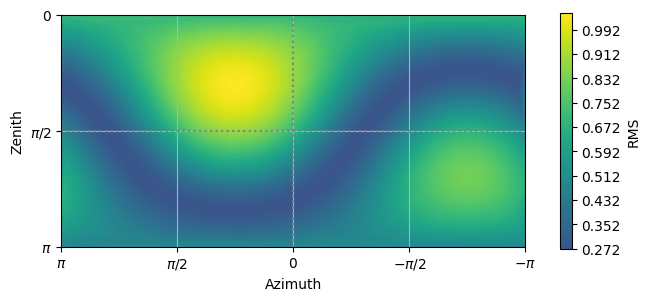

In [19]:
# Berechnung der Schalleinfallsrichtungen + Energien über Beamforming:

# Definieren des Beamformers in Nierenform (top, links, rechts, hinten)
beam_def = spa.parsa.sh_beamformer_from_pattern('cardioid', 3, [0,1.5*np.pi,0.5*np.pi, np.pi], [0.5*np.pi, 0, 0, 0])
beam_sig = spa.parsa.sh_beamform(beam_def,HOAS)
spa.plot.sh_rms_map(beam_def) # (!!)stimmt noch nicht(!!)

# (evtl. eher sph.design_sph_filterbank() nutzen und mit sph.sph_filterbank_reconstruction_factor() korrigieren)

# Berechnung der Richtungsenergien
# front = sum(beam_sig[4, tl:tu])
back = sum(beam_sig[3, tl:tu])
top = sum(beam_sig[0, tl:tu])
left = sum(beam_sig[1, tl:tu])
right = sum(beam_sig[2, tl:tu])

## was ist mit spa.sph.inverse_sht()???


C:\Users\moinm\AppData\Local\Temp\ipykernel_2160\1748918265.py:7: RuntimeWarning: divide by zero encountered in log10
  coord_cart_r = coord_cart * np.log10(vek_r)
C:\Users\moinm\AppData\Local\Temp\ipykernel_2160\1748918265.py:7: RuntimeWarning: invalid value encountered in multiply
  coord_cart_r = coord_cart * np.log10(vek_r)


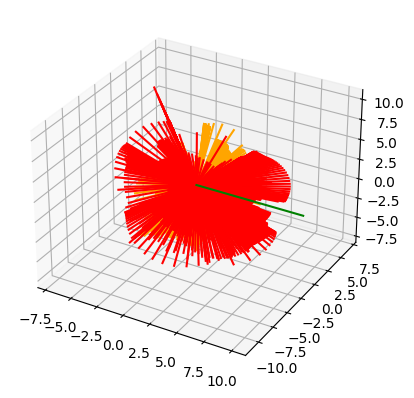

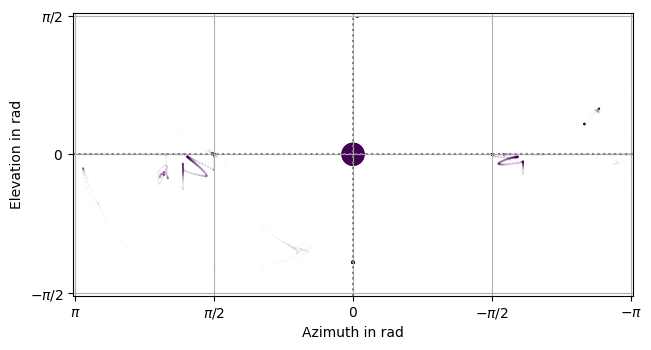

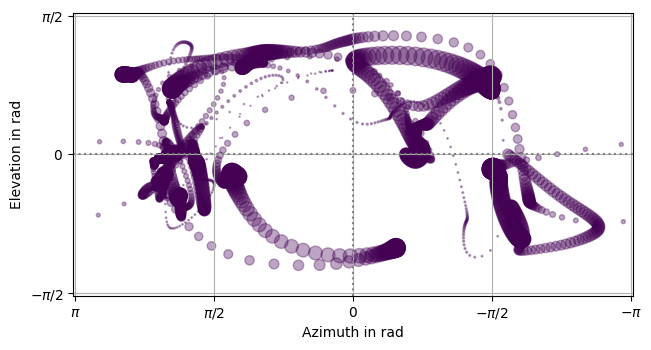

In [29]:
# Berechnung der Schalleinfallsrichtungen über Pseudointensität (IRIS)
vek_azi, vek_zen, vek_r = spa.parsa.pseudo_intensity(ambi_b, 55, f_bp = None)

# Berechnung der Intensitätsvektoren
# coord_ps_i = spa.utils.sph2cart(vek_azi, vek_zen, vek_r)
coord_cart = spa.utils.dir2cart(vek_azi, vek_zen)
coord_cart_r = coord_cart * np.log10(vek_r)
# x_pf, y_pf, z_pf = pf.classes.coordinates.cy


## Plot der Intensitätsvektoren
# Definition des Evaluationszeitraumes
t_ev = int(ambi_b.fs * 0.1)
t_ev2 = int(ambi_b.fs * 0.15)

# Extraktion der Vektorendpunkte (benötigt, für Zeitoptimierung)
x_pl = coord_cart_r[0]
y_pl = coord_cart_r[1]
z_pl = coord_cart_r[2]

# Plot der Vektoren
ax = plt.axes(projection='3d')
for i in range(t_ev, t_ev2):
    ax.plot3D([0,x_pl[i]],[0,y_pl[i]],[0,z_pl[i]],'orange')

for i in range(0, t_ev):
    ax.plot3D([0,x_pl[i]],[0,y_pl[i]],[0,z_pl[i]],'red')

ax.plot3D([0,10],[0,0],[0,0],'green')

# ax.axes.set_xlim3d(left=-1, right=1)
# ax.axes.set_ylim3d(bottom=-1, top=1)
# ax.axes.set_zlim3d(bottom=-1, top=1)

spa.plot.doa(vek_azi[0:t_ev], vek_zen[0:t_ev], vek_r[0:t_ev])
spa.plot.doa(vek_azi[t_ev:t_ev2], vek_zen[t_ev:t_ev2], vek_r[t_ev:t_ev2])

# bzw. über SDM

In [ ]:
# Beschreibung des Parameters

# TS - Top/Sides(left,right)

TS = 10*np.log10((top)**2/(left + right)**2)
print('TS = ' + str(TS))

# TH - Top/Horizontal(left,right,back)

TH = 10*np.log10((top)**2/(left + right + back)**2)
print('TH = ' + str(TH))


TS = -11.46460239973491
TH = -14.986427580848531


(-1.0, 1.0)

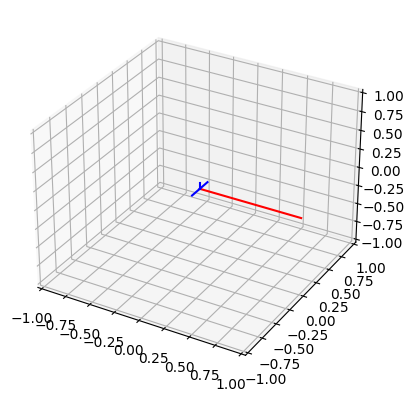

In [ ]:

# Darstellung des Parameters

# Vorläufiger Plot der reinen IR
# spa.plot.sh_rms_map(RIR_Mf, title="Raw Spatial Impulse Response (with SH)")

ax = plt.axes(projection='3d')
ax.plot3D([0,1],[0,0],[0,0],'red')
# ax.plot3D([1],[1],[1])
ax.plot3D([0,0],[0,0],[0,top],'blue')
ax.plot3D([0,0],[0,left],[0,0],'blue')
ax.plot3D([0,0],[0,-right],[0,0],'blue')

ax.axes.set_xlim3d(left=-1, right=1) 
ax.axes.set_ylim3d(bottom=-1, top=1) 
ax.axes.set_zlim3d(bottom=-1, top=1)